In [1]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import jax
import sys
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '../')
from plotting_helper_funcs import *
from utils import *

rng = np.random.default_rng(seed=1234)

%env CUDA_VISIBLE_DEVICES=1

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


env: CUDA_VISIBLE_DEVICES=1


Now load in all of the posterior idata and the posterior predictive samples...

In [15]:
savedir = '../../../results/MAPK/param_est/HF96_synthetic_data/'

model_info = json.load(open('../param_est/model_info.json'))
model_names = list(model_info.keys())
model_names.remove('huang_ferrell_1996')
display_names = [model_info[model]['display_name'] for model in model_names]

idata = {}
posterior_traj_samples = {}
ss = {}
log_marginal_likes = []

for model in model_names:
    idata[model], ss[model] = load_smc_samples_to_idata(savedir+model+'/'+model+'_smc_samples.json')
    posterior_traj_samples[model] = np.load(savedir+model+'/traj_predict.npy')

    posterior_traj_samples[model][np.isinf(posterior_traj_samples[model])] = np.nan

    
# Log marginal likelihoods
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['kholodenko_2000']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['levchenko_2000']['log_marginal_likelihood']]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['hornberg_2005']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['birtwistle_2007']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['orton_2009']['log_marginal_likelihood'][0]]))
log_marginal_likes.append( np.mean([chain[-1] for chain in ss['vonKriegsheim_2009']['log_marginal_likelihood'][0]])) 
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['shin_2014']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['ryu_2015']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['kochanczyk_2017']['log_marginal_likelihood']]))

log_marginal_likes = np.array(log_marginal_likes)

# get data training data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
# colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# # this one gets to 9 colors by removing the darkest green ('#00441b') and lightest green ('#f7f7f7',)
# colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']

colors = get_color_pallette()

# remove the fisrt color, becuase it is for H' 1996
colors = colors[1:]
# remove the 4th to last color bc we dont have 10 models here
colors.remove(colors[-4])

# load trajectory data
inputs_traj, data_traj, data_std_traj, times_traj = load_data_json('../../../results/MAPK/HF_96_traj_data.json', data_std=True, time=True)
data_time_to_mins = 60


Now run arviz model comparison get eldpd_loo for each model and save to a dict

In [16]:
compare_data_waic_pbma = az.compare(idata, ic='waic', method='BB-pseudo-BMA', seed=rng)
compare_data_loo_pbma = az.compare(idata, ic='loo', method='BB-pseudo-BMA', seed=rng)
compare_data_waic_stack = az.compare(idata, ic='waic', method='stacking', seed=rng)
compare_data_loo_stack = az.compare(idata, ic='loo', method='stacking', seed=rng)

/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/li

Bayesian model averaging - plot bar plot of model probabilities

In [17]:
n_models = len(log_marginal_likes)
prior_prob = 1/n_models

normalizing_constant = np.sum(prior_prob*np.exp(log_marginal_likes))
model_probs = prior_prob*np.exp(log_marginal_likes)/normalizing_constant

Generate predictive samples from the averaged predictive density

In [18]:
# first wiith posterior predictive samples
loo_pbma_combined = np.zeros_like(posterior_traj_samples['kholodenko_2000'])
loo_stack_combined = np.zeros_like(posterior_traj_samples['kholodenko_2000'])
loo_bma_combined = np.zeros_like(posterior_traj_samples['kholodenko_2000'])
for i, name in enumerate(model_names):
    loo_pbma_combined += compare_data_loo_pbma.loc[name]['weight']*posterior_traj_samples[name]
    loo_stack_combined += compare_data_loo_stack.loc[name]['weight']*posterior_traj_samples[name]
    loo_bma_combined += model_probs[i]*posterior_traj_samples[name]

Now compute RMSE for each model at the intermediate EGF input (0.00473151 mM)

In [32]:
data_traj.shape

(3, 60)

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_73864/2197756464.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


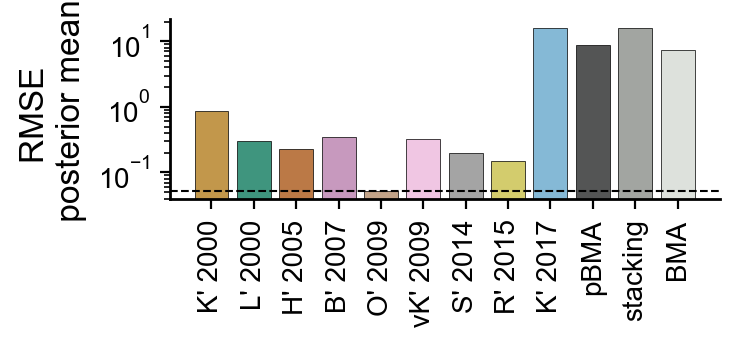

In [48]:
input_idx = 1 # we want to take the middle input 4.7e-3ish

# post pred samples
RMSE_samples = []
for i, name in enumerate(model_names):
    RMSE_samples.append(np.sqrt(np.nanmean((np.nanmean(posterior_traj_samples[name][:,input_idx,:], axis=0) - data_traj[input_idx,:])**2)))

# get index of min RMSE
# do this before adding MMI
min_index = np.argmin(RMSE_samples)

# add RMSE for BMA and pseudo-BMA
RMSE_samples.append(np.sqrt(np.nanmean((np.nanmean(loo_pbma_combined[:,input_idx,:], axis=0) - data_traj[input_idx,:])**2)))
RMSE_samples.append(np.sqrt(np.nanmean((np.nanmean(loo_stack_combined[:,input_idx,:], axis=0) - data_traj[input_idx,:])**2)))
RMSE_samples.append(np.sqrt(np.nanmean((np.nanmean(loo_bma_combined[:,input_idx,:], axis=0) - data_traj[input_idx,:])**2)))

# make a plot
fig, ax = get_sized_fig_ax(2.75, 0.9)
bar = ax.bar(display_names + ['pBMA', 'stacking', 'BMA'], RMSE_samples, edgecolor='k', alpha=0.85)
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
    
xlim = ax.get_xlim()
ax.plot(xlim, [RMSE_samples[min_index]]*2, 'k--', linewidth=0.75)
ax.set_xlim(xlim)

ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('RMSE \n posterior mean ', fontsize=12.0)
ax.set_yscale('log')

fig.savefig('../../../results/MAPK/mmi/HF96_DR_pred_traj/RMSE.pdf', transparent=True)

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_73864/1587457229.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


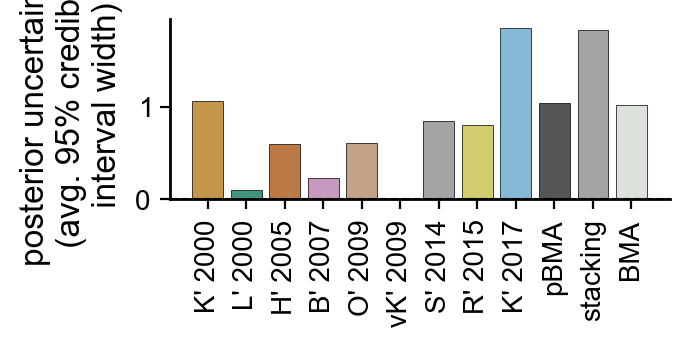

In [49]:
# posterior predictive samples
posterior_uncertainty_95_pred = []
for i, name in enumerate(model_names):
    posterior_uncertainty_95_pred.append(np.nanmean(np.diff(np.nanquantile(posterior_traj_samples[name][:,input_idx,:], [0.025, 0.975], axis=0), axis=0)))

# get index of min uncertainty
min_index_95 = np.argmin(posterior_uncertainty_95_pred)

# add RMSE for BMA and pseudo-BMA
posterior_uncertainty_95_pred.append(np.nanmean(np.diff(np.nanquantile(loo_pbma_combined[:,input_idx,:], [0.025, 0.975], axis=0), axis=0)))
posterior_uncertainty_95_pred.append(np.nanmean(np.diff(np.nanquantile(loo_stack_combined[:,input_idx,:], [0.025, 0.975], axis=0), axis=0)))
posterior_uncertainty_95_pred.append(np.nanmean(np.diff(np.nanquantile(loo_bma_combined[:,input_idx,:], [0.025, 0.975], axis=0), axis=0)))

# make a plot
fig, ax = get_sized_fig_ax(2.5, 0.9)
bar = ax.bar(display_names + ['pBMA', 'stacking', 'BMA'], posterior_uncertainty_95_pred, edgecolor='k', alpha=0.85)
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [posterior_uncertainty_95_pred[min_index_95]]*2, 'k--', linewidth=0.75)
ax.set_xlim(xlim)
ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=12.0)
# ax.set_yticks([0, 0.25, 0.5])
# ax.set_yticklabels([0, 0.25, 0.5], fontsize=10.0)

ylim = ax.get_ylim()
# ax.plot([9.5,9.5], ylim, 'k', linewidth=0.75)
ax.set_ylim(ylim)
# ax.set_yscale('log')
fig.savefig('../../../results/MAPK/mmi/HF96_DR_pred_traj/post_uncert_95.pdf', transparent=True)

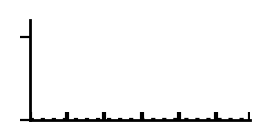

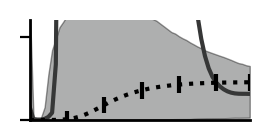

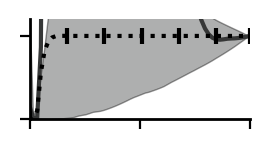

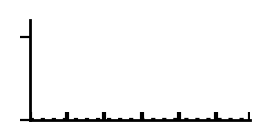

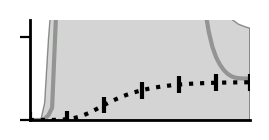

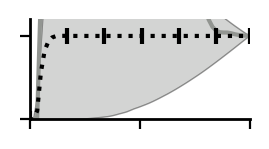

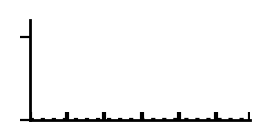

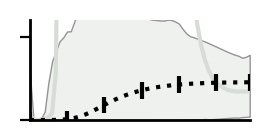

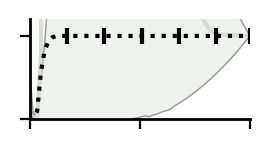

In [51]:
# make plots
trajs_mmi = {'loo_pbma_combined_traj':loo_pbma_combined,
         'loo_stack_combined':loo_stack_combined,
         'loo_bma_combined':loo_bma_combined}

fig_savedir = '../../../results/MAPK/mmi/HF96_DR_pred_traj/'
cols = [colors[-3], colors[-2], colors[-1]]
for idx, name in enumerate(trajs_mmi.keys()):
    plot_posterior_trajectories(trajs_mmi[name], data_traj, data_std_traj, times_traj, cols[idx], 
                                            inputs_traj, fig_savedir,
                                            name, data_time_to_mins=60,
                                            width=1.1, height=0.5, 
                                            data_downsample=10,
                                            ylim=[[0.0, 1.2], [0.0, 1.2], [0.0, 1.2]],
                                            y_ticks=[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]],
                                            fname=name+'_pred_traj_', labels=False)